# Grid Search

In [63]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier

## 1. Reading in the data
## 2. Features and target selection

In [64]:
pwd = os.getcwd()
data= os.path.join(pwd, "data.csv")
df = pd.read_csv(data)
features = df[["Pclass", "Sex", "Fare"]]
target = df[["Survived"]]

## 3. Transformer

In [65]:
ct = ColumnTransformer([
    ("onehot", OneHotEncoder(sparse=False), ["Pclass", "Sex"]),
    ("scaling", StandardScaler(),["Fare"])
    ])

features_fit_trans = ct.fit_transform(features)

## 4. Splitting data

In [66]:
X_trainval, X_test, y_trainval, y_test = train_test_split(features_fit_trans, np.ravel(target), random_state=0, stratify=target)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, np.ravel(y_trainval), random_state=0, stratify=y_trainval)

## 5. Simple Grid Search

In [67]:
best_score = 0
for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {"C":C, "gamma":gamma}
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test,y_test)

In [68]:
print(
    "\nSize of training set: {}    Size of validation set: {}\n".format(X_train.shape[0], X_valid.shape[0])
)

print(
    "Best score on validaiton set: {:.2f}".format(best_score)
)

print(
    "Best parameters: ", best_parameters
)

print(
    "Test set score with best parameters: {:.2f}".format(test_score)
)


Size of training set: 501    Size of validation set: 167

Best score on validaiton set: 0.80
Best parameters:  {'C': 100, 'gamma': 0.1}
Test set score with best parameters: 0.78


## Grid Search with Cross Validation

In [69]:
best_score_cv = 0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        svm_cv = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm_cv, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        if score > best_score_cv:
            best_score_cv = score
            best_parameters_cv = {"C":C, "gamma":gamma}
svm_cv = SVC(**best_parameters_cv)
svm_cv.fit(X_trainval, y_trainval)
test_score_cv = svm_cv.score(X_test,y_test)

In [70]:
print(
    "\nSize of training set: {}    size of validation set: {}\n".format(X_train.shape[0], X_valid.shape[0])
)

print(
    "Best score on validaiton set: {:.2f}".format(best_score_cv)
)

print(
    "Best parameters: ", best_parameters_cv
)

print(
    "Test set score with best parameters: {:.2f}".format(test_score_cv)
)


Size of training set: 501    size of validation set: 167

Best score on validaiton set: 0.82
Best parameters:  {'C': 100, 'gamma': 0.1}
Test set score with best parameters: 0.78


## Grid Search with Cross Validation (GridSearchCV)

As default:
- For classification, GridSearchCV uses stratified k-fold cross-validaiton 
- For regression, GridSearchCV uses k-fold cross-validaiton

In [71]:
param_grid = {"C":[0.001,0.01,0.1,1,10,100],
	"gamma":[0.001,0.01,0.1,1,10,100]}

#[0.001,0.01,0.1,1,10,100]
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)


# with non-numeric parameters, list of dictionaries
# param_grid = [{"kernel" : ["rbf"], "C":[0.001,0.01,0.1,1,10,100],"gamma":[0.001,0.01,0.1,1,10,100]},{"kernel" : ["linear"],"C":[0.001,0.01,0.1,1,10,100]}]


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [72]:
print(
    "\nTest set score: {:.2f}\n".format(grid_search.score(X_test, y_test))
)
print(
    "Best parameters: {}".format(grid_search.best_params_)
)
print(
    "Best cross-validation score: {:.2f}".format(grid_search.best_score_)
)
print(
    "Best best_estimator_: {}".format(grid_search.best_estimator_)
)


Test set score: 0.78

Best parameters: {'C': 10, 'gamma': 1}
Best cross-validation score: 0.82
Best best_estimator_: SVC(C=10, gamma=1)


In [73]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005840,0.000115,0.003446,0.000124,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.613861,0.61,0.62,...,0.616772,0.004137,24,0.6175,0.618454,0.61596,0.61596,0.61596,0.616767,0.001033
1,0.005201,0.000286,0.003039,0.000138,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.613861,0.61,0.62,...,0.616772,0.004137,24,0.6175,0.618454,0.61596,0.61596,0.61596,0.616767,0.001033
2,0.005078,0.000268,0.002999,0.000286,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.613861,0.61,0.62,...,0.616772,0.004137,24,0.6175,0.618454,0.61596,0.61596,0.61596,0.616767,0.001033
3,0.005200,0.000285,0.003050,0.000232,0.001,1,"{'C': 0.001, 'gamma': 1}",0.613861,0.61,0.62,...,0.616772,0.004137,24,0.6175,0.618454,0.61596,0.61596,0.61596,0.616767,0.001033
4,0.005476,0.000260,0.003295,0.000311,0.001,10,"{'C': 0.001, 'gamma': 10}",0.613861,0.61,0.62,...,0.616772,0.004137,24,0.6175,0.618454,0.61596,0.61596,0.61596,0.616767,0.001033


In [74]:
scores_hm = np.array(results.mean_test_score).reshape(6,6)

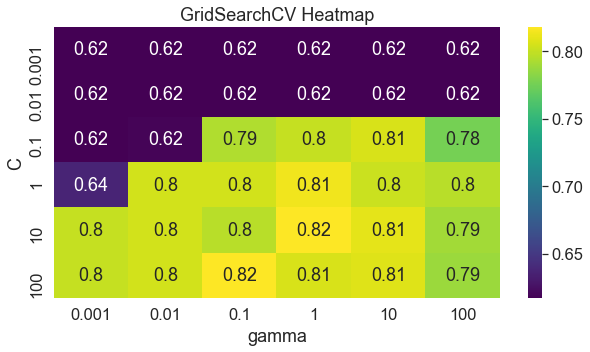

In [75]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

sns.heatmap(scores_hm, annot=True, cmap="viridis", xticklabels=param_grid["gamma"], yticklabels=param_grid["C"])
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("GridSearchCV Heatmap")
plt.show()

# Nested cross-validation

- using all available data
- computationally taxing:
    - param_grid (gamma and C): 36 combination
    - cv=5, 25 combination
    - 36*35 = 900 models being built
- use argument n_jobs = -1 to use all CPUs

In [80]:
param_grid_nested = {"C":[0.001,0.01,0.1,1,10,100],
	"gamma":[0.001,0.01,0.1,1,10,100]}

scores_nested = cross_val_score(GridSearchCV(SVC(),param_grid=param_grid_nested,cv=5, n_jobs=-1),features_fit_trans, np.ravel(target), cv=5, n_jobs=-1)

In [77]:
print(
    "Nested Cross-validation scores: \n", scores_nested
)

print(
    "\nMean Nested cross-validaiton score: ", scores_nested.mean() 
)

Nested Cross-validation scores: 
 [0.74860335 0.79775281 0.80898876 0.79775281 0.83146067]

Mean Nested cross-validaiton score:  0.7969116816270164


In [78]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.6143497757847534

In [79]:
cross_val_score(dummy, features_fit_trans, np.ravel(target), cv=5).mean()

0.6161634548992531